# Step 0: Set-up

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!pip install tabulate
!pip install matplotlib seaborn

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import ttest_ind
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

Mounted at /content/drive


# Step 1: Exploratory Data Analysis

In [ ]:
# Paths to the uploaded files
clin_data_path = '/content/drive/MyDrive/Bladder_cancer_ML/20191105_BC_ClinData_233rows.csv'
gene_exp_data_path = '/content/drive/MyDrive/Bladder_cancer_ML/20191105_BC_GeneExpData_withAnno_233.tsv'

# Reading the clinical data CSV file
clin_data_df = pd.read_csv(clin_data_path)

# Reading the gene expression data TSV file
gene_exp_data_df = pd.read_csv(gene_exp_data_path, sep='\t')

# Displaying the first few rows of each DataFrame to ensure they are read correctly
print("Clinical Data:")
print(clin_data_df.head())

print("\nGene Expression Data:")
print(gene_exp_data_df.head())

Clinical Data:
  Sample.name  SEX  AGE  invasiveness  Intravesical.therapy  systemic.chemo  \
0       BS017  NaN  NaN           NaN                   NaN             NaN   
1       BS038  NaN  NaN           NaN                   NaN             NaN   
2       BS039  NaN  NaN           NaN                   NaN             NaN   
3       BS040  NaN  NaN           NaN                   NaN             NaN   
4       BS041  NaN  NaN           NaN                   NaN             NaN   

  TMN.stage  Grade  Classifier.recurrence  \
0       NaN    NaN                    NaN   
1       NaN    NaN                    NaN   
2       NaN    NaN                    NaN   
3       NaN    NaN                    NaN   
4       NaN    NaN                    NaN   

   Classifier.progression.(non-muscle.invasive)  ...  \
0                                           NaN  ...   
1                                           NaN  ...   
2                                           NaN  ...   
3              

In [ ]:
# Ensuring column names are consistent
clin_data_df.columns = clin_data_df.columns.str.strip()

# Defining the column that indicates cancer types
cancer_type_column = 'PrimaryBladderCancerType'

In [ ]:
# Function to summarize NaN values for each group
def summarize_nan_by_group(data, group_column):
    grouped_data = data.groupby(group_column)
    nan_summary_by_group = grouped_data.apply(lambda x: x.isna().sum())
    total_nan_by_group = grouped_data.apply(lambda x: x.isna().sum().sum())
    return nan_summary_by_group, total_nan_by_group

# Summarizing NaN values in clinical data for each cancer type
clin_nan_summary_by_cancer, clin_total_nan_by_cancer = summarize_nan_by_group(clin_data_df, cancer_type_column)

print("NaN Summary for Clinical Data by Cancer Type:")
print(clin_nan_summary_by_cancer)
print(f"Total NaN values in Clinical Data by Cancer Type:\n{clin_total_nan_by_cancer}\n")

NaN Summary for Clinical Data by Cancer Type:
                                    Sample.name  SEX  AGE  invasiveness  \
PrimaryBladderCancerType                                                  
Bladder mucosae surrounding cancer            0   58   58            58   
Normal bladder mucosae                        0   10   10            10   
Primary_BC_Invasive                           0    0    0             0   
Primary_BC_Superficial                        0    0    0             0   

                                    Intravesical.therapy  systemic.chemo  \
PrimaryBladderCancerType                                                   
Bladder mucosae surrounding cancer                    58              58   
Normal bladder mucosae                                10              10   
Primary_BC_Invasive                                   62               0   
Primary_BC_Superficial                                 0               0   

                                    TMN.stage 

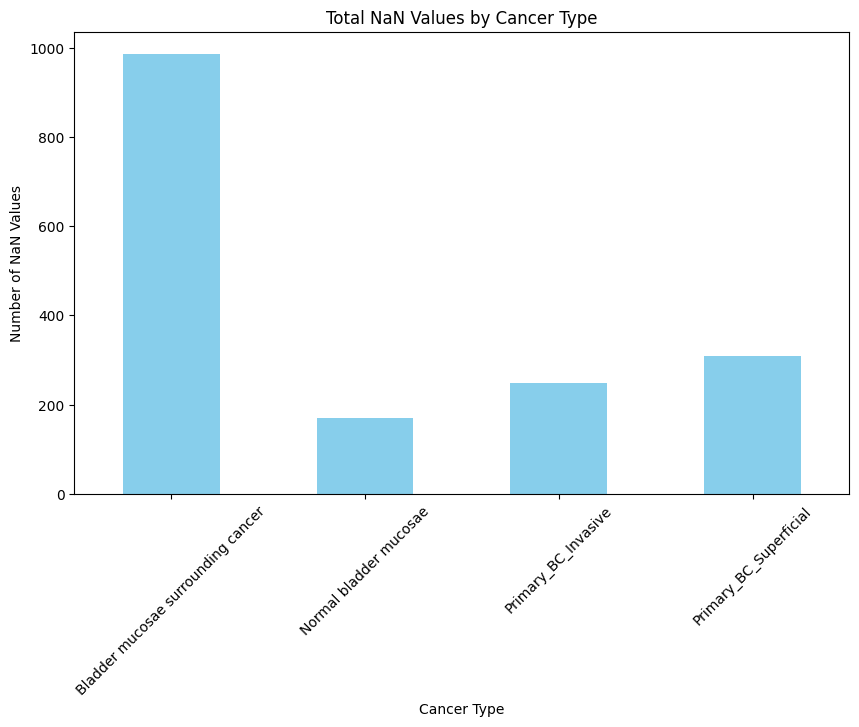

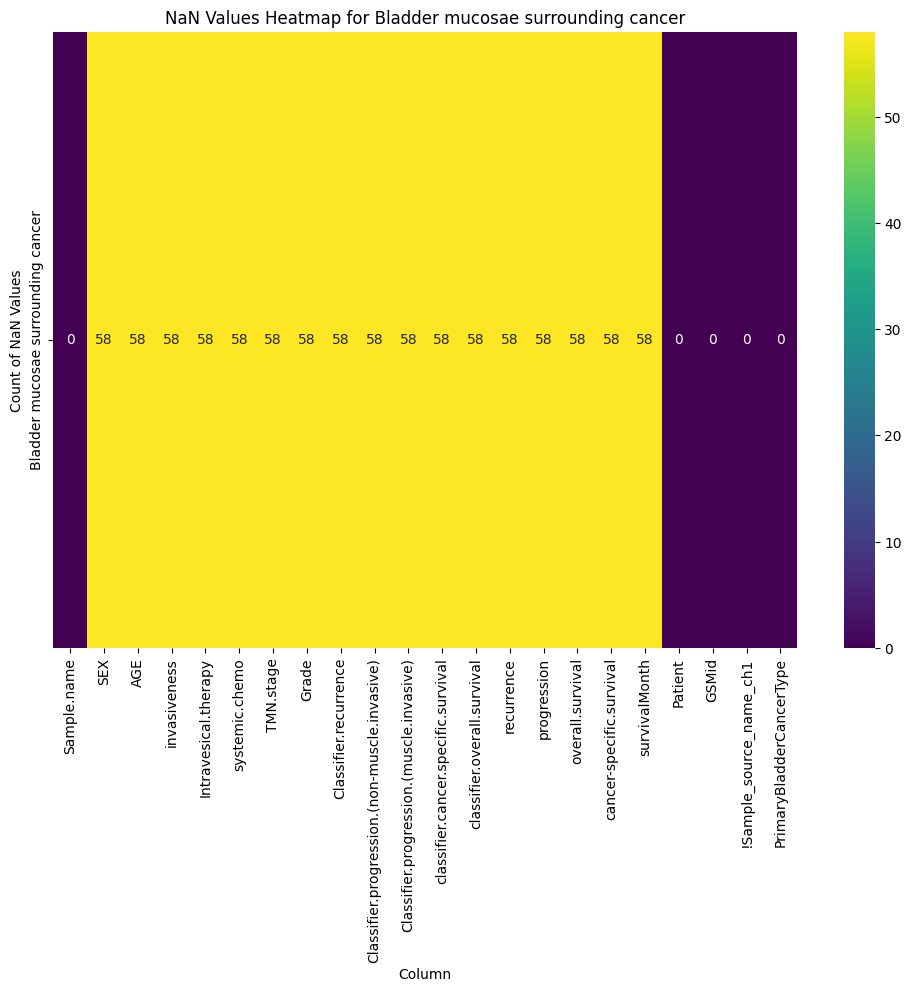

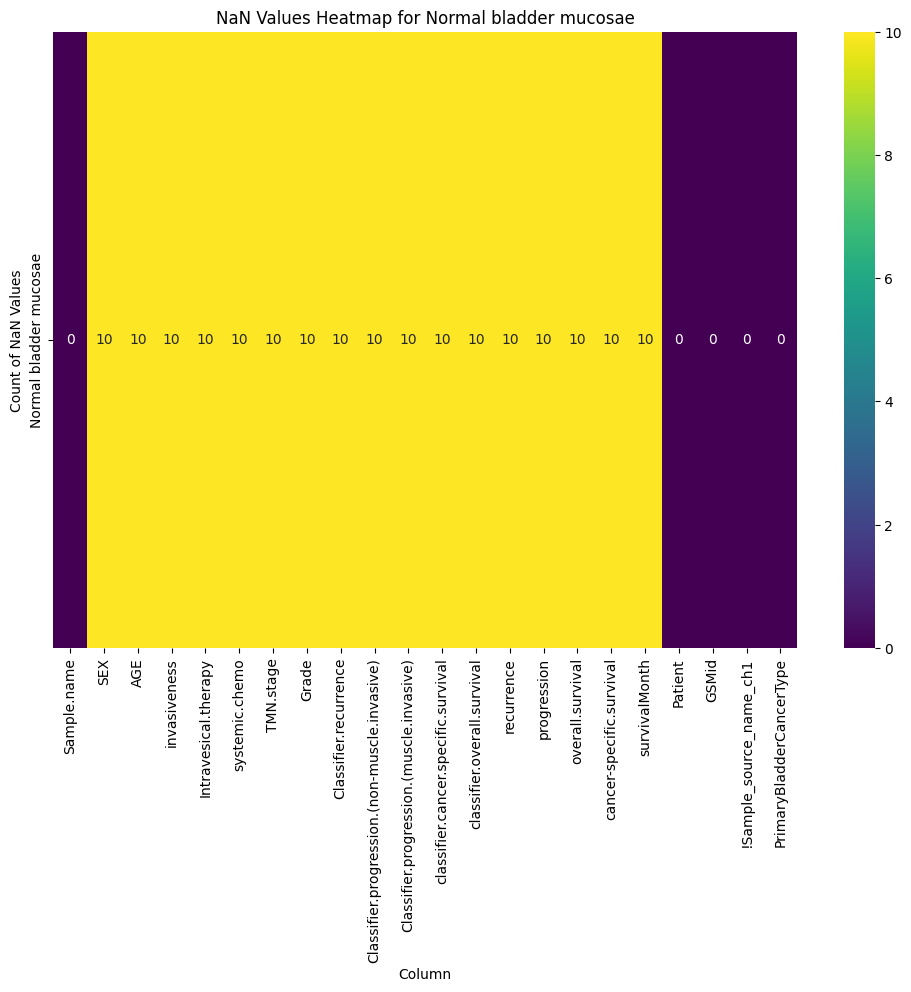

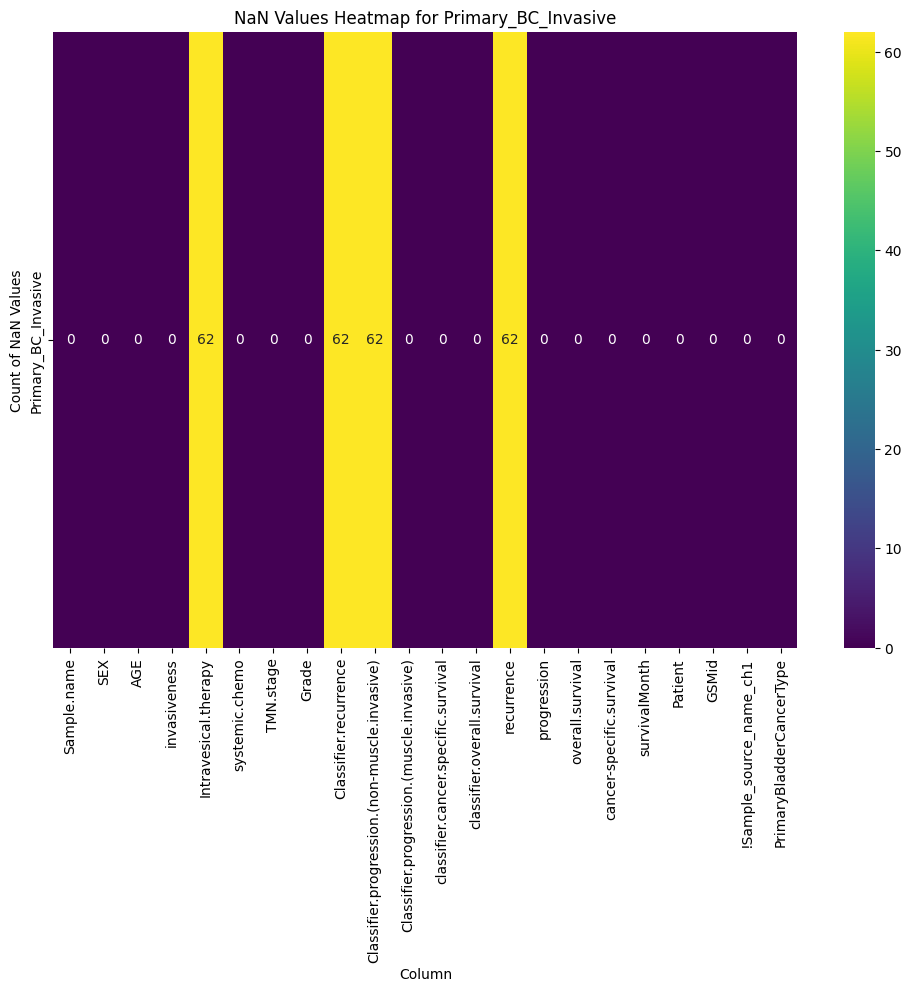

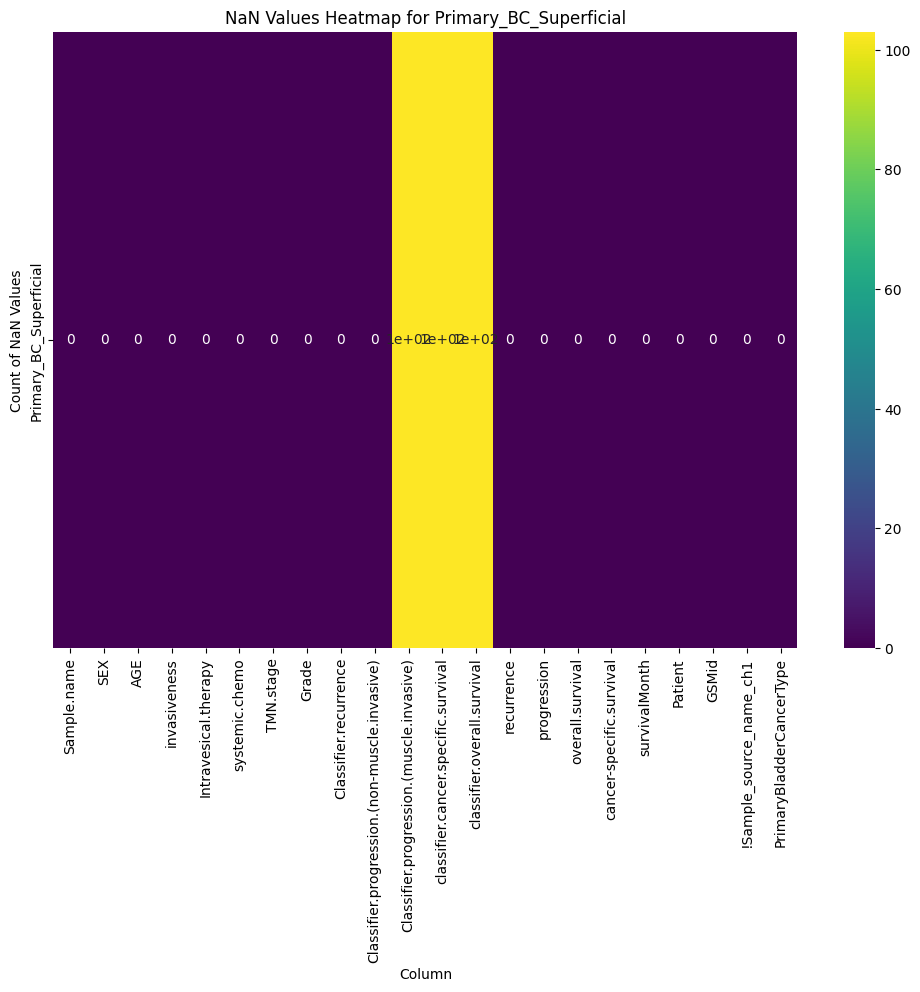

In [ ]:
# Ensuring column names are consistent
clin_data_df.columns = clin_data_df.columns.str.strip()

# Defining the column that indicates cancer types
cancer_type_column = 'PrimaryBladderCancerType'

# Function to summarize NaN values for each group
def summarize_nan_by_group(data, group_column):
    grouped_data = data.groupby(group_column)
    nan_summary_by_group = grouped_data.apply(lambda x: x.isna().sum())
    total_nan_by_group = grouped_data.apply(lambda x: x.isna().sum().sum())
    return nan_summary_by_group, total_nan_by_group

# Summarizing NaN values in clinical data for each cancer type
clin_nan_summary_by_cancer, clin_total_nan_by_cancer = summarize_nan_by_group(clin_data_df, cancer_type_column)

# Plotting total NaN values by cancer type
plt.figure(figsize=(10, 6))
clin_total_nan_by_cancer.plot(kind='bar', color='skyblue')
plt.title('Total NaN Values by Cancer Type')
plt.xlabel('Cancer Type')
plt.ylabel('Number of NaN Values')
plt.xticks(rotation=45)
plt.show()

# Plotting NaN values by column for each cancer type using heatmap
for cancer_type in clin_nan_summary_by_cancer.index.get_level_values(0).unique():
    plt.figure(figsize=(12, 8))
    summary_table = clin_nan_summary_by_cancer.loc[cancer_type]
    sns.heatmap(summary_table.to_frame().T, annot=True, cmap='viridis', cbar=True)
    plt.title(f'NaN Values Heatmap for {cancer_type}')
    plt.xlabel('Column')
    plt.ylabel('Count of NaN Values')
    plt.show()

In [ ]:
# Function to summarize NaN values in gene expression data by sample type
def summarize_nan_in_gene_exp(data, clinical_data, group_column):
    nan_summary = {}
    for cancer_type, samples in clinical_data.groupby(group_column):
        sample_ids = samples['GSMid']
        gene_exp_samples = data[sample_ids]
        nan_summary[cancer_type] = gene_exp_samples.isna().sum().sum()
    return pd.Series(nan_summary)

# Summarizing NaN values in gene expression data for each cancer type
gene_exp_nan_summary_by_cancer = summarize_nan_in_gene_exp(gene_exp_data_df, clin_data_df, cancer_type_column)

print("NaN Summary for Gene Expression Data by Cancer Type:")
print(gene_exp_nan_summary_by_cancer)

NaN Summary for Gene Expression Data by Cancer Type:
Bladder mucosae surrounding cancer    0
Normal bladder mucosae                0
Primary_BC_Invasive                   0
Primary_BC_Superficial                0
dtype: int64


# Step 2: Data Pre-Processing

In [ ]:
# Merging clinical data with gene expression data based on GSMid
merged_data = pd.merge(clin_data_df[['GSMid', 'PrimaryBladderCancerType']],
                       gene_exp_data_df.T,
                       left_on='GSMid',
                       right_index=True)

# Displaying the merged data
print("Merged Data with Cancer Type:")
print(merged_data.head())

Merged Data with Cancer Type:
       GSMid            PrimaryBladderCancerType  ILMN_1651199|LOC643334  \
0  GSM340547  Bladder mucosae surrounding cancer                    7.00   
1  GSM340548  Bladder mucosae surrounding cancer                    6.98   
2  GSM340549  Bladder mucosae surrounding cancer                    7.05   
3  GSM340550  Bladder mucosae surrounding cancer                    7.53   
4  GSM340551  Bladder mucosae surrounding cancer                    7.21   

   ILMN_1651209|SLC35E2  ILMN_1651210|DUSP22  ILMN_1651217|PDCD1LG2  \
0                  8.01                10.12                   6.86   
1                  7.83                10.25                   6.90   
2                  7.67                10.44                   6.86   
3                  6.97                 9.90                   7.38   
4                  7.91                10.63                   7.04   

   ILMN_1651221|LOC642820  ILMN_1651228|RPS28  ILMN_1651229|IPO13  \
0                

In [ ]:
# Identifying normal and cancer samples
normal_samples = merged_data[merged_data['PrimaryBladderCancerType'] == 'Normal bladder mucosae']
cancer_types = merged_data['PrimaryBladderCancerType'].unique()
cancer_types = [ct for ct in cancer_types if ct != 'Normal bladder mucosae']

significant_genes = {}

# Performing t-tests for each cancer type
for cancer_type in cancer_types:
    cancer_samples = merged_data[merged_data['PrimaryBladderCancerType'] == cancer_type]

    significant_genes[cancer_type] = []
    for gene in gene_exp_data_df.index:
        normal_expression = normal_samples[gene]
        cancer_expression = cancer_samples[gene]
        t_stat, p_val = ttest_ind(normal_expression, cancer_expression, nan_policy='omit')
        if p_val < 0.01:  # Using a significance level of 0.01
            significant_genes[cancer_type].append((gene, p_val))

# Displaying significant genes
for cancer_type, genes in significant_genes.items():
    print(f"\nSignificant Genes for {cancer_type}:")
    for gene, p_val in genes:
        print(f"Gene: {gene}, P-Value: {p_val}")


Streaming output truncated to the last 5000 lines.
Gene: ILMN_1692948|CCDC90B, P-Value: 0.00018677579353692042
Gene: ILMN_1692962|CTDSP2, P-Value: 0.000479381869297469
Gene: ILMN_1692967|AXIN1, P-Value: 1.778283858452548e-06
Gene: ILMN_1692994|C11orf52, P-Value: 0.007714049926097231
Gene: ILMN_1693039|ZFPL1, P-Value: 7.875545202308513e-05
Gene: ILMN_1693136|VTI1B, P-Value: 7.567188580653939e-06
Gene: ILMN_1693210|NSMCE2, P-Value: 0.002959160628932914
Gene: ILMN_1693220|AKAP11, P-Value: 3.2471482083178276e-05
Gene: ILMN_1693223|LOC642520, P-Value: 0.0092189119570962
Gene: ILMN_1693233|KIAA0513, P-Value: 0.0017889995772406597
Gene: ILMN_1693259|PDCD6IP, P-Value: 0.006991308279778049
Gene: ILMN_1693310|ITFG1, P-Value: 0.0006197643837795041
Gene: ILMN_1693319|EYA4, P-Value: 7.771871951522198e-07
Gene: ILMN_1693338|CYP1B1, P-Value: 0.0008165923152487769
Gene: ILMN_1693340|RAC3, P-Value: 0.0030800284066997983
Gene: ILMN_1693345|CPEB1, P-Value: 4.829249835155191e-07
Gene: ILMN_1693420|LOC6449

In [ ]:
# Extracting the top significant genes for each cancer type
top_significant_genes = {cancer_type: [gene for gene, p_val in sorted(genes, key=lambda x: x[1])[:500]]
                         for cancer_type, genes in significant_genes.items()}  # Top 500 significant genes

# Preparing a dictionary to hold the new columns
new_columns = {}

# Collecting all new columns into the dictionary
for cancer_type, genes in top_significant_genes.items():
    for gene in genes:
        if gene not in new_columns:  # Avoid duplicates
            new_columns[gene] = merged_data.apply(
                lambda row: gene_exp_data_df.loc[gene, row['GSMid']] if row['GSMid'] in gene_exp_data_df.columns else np.nan,
                axis=1
            )

# Converting the dictionary to a DataFrame
new_columns_df = pd.DataFrame(new_columns)

# Concatenating the new columns with the original clinical data
clin_data_df = pd.concat([clin_data_df.reset_index(drop=True), new_columns_df.reset_index(drop=True)], axis=1)

# Displaying the updated clinical data with significant genes
print("\nUpdated Clinical Data with Significant Genes:")
print(clin_data_df.head())


Updated Clinical Data with Significant Genes:
  Sample.name  SEX  AGE  invasiveness  Intravesical.therapy  systemic.chemo  \
0       BS017  NaN  NaN           NaN                   NaN             NaN   
1       BS038  NaN  NaN           NaN                   NaN             NaN   
2       BS039  NaN  NaN           NaN                   NaN             NaN   
3       BS040  NaN  NaN           NaN                   NaN             NaN   
4       BS041  NaN  NaN           NaN                   NaN             NaN   

  TMN.stage  Grade  Classifier.recurrence  \
0       NaN    NaN                    NaN   
1       NaN    NaN                    NaN   
2       NaN    NaN                    NaN   
3       NaN    NaN                    NaN   
4       NaN    NaN                    NaN   

   Classifier.progression.(non-muscle.invasive)  ...  ILMN_1749070|HLA-DPB1  \
0                                           NaN  ...                   7.52   
1                                           NaN  

In [ ]:
clin_data_df.head()

,Sample.name,SEX,AGE,invasiveness,Intravesical.therapy,systemic.chemo,TMN.stage,Grade,Classifier.recurrence,Classifier.progression.(non-muscle.invasive),...,ILMN_1749070|HLA-DPB1,ILMN_1853477|,ILMN_1652996|LOC440345,ILMN_1733035|LOC653784,ILMN_1666995|LOC647970,ILMN_1702218|POLI,ILMN_1804832|RNASE4,ILMN_1706765|NDUFS6,ILMN_1689578|TLR3,ILMN_1816015|
0,BS017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.52,7.43,11.80,9.36,6.97,7.62,8.39,14.66,7.11,7.24
1,BS038,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.85,7.46,11.77,9.81,7.11,7.69,8.08,14.32,7.72,7.20
2,BS039,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.93,7.42,10.85,8.93,7.60,8.05,10.66,13.65,7.76,7.48
3,BS040,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,9.26,7.30,11.47,8.66,7.21,7.42,10.08,13.79,7.28,7.43
4,BS041,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.03,7.55,10.00,8.95,7.92,7.60,10.16,13.86,7.23,7.55


In [ ]:
# Function to clean column names
def clean_column_names(df):
    new_columns = {}
    for col in df.columns:
        if '|' in col:
            new_columns[col] = col.split('|')[1]  # Keep only the part after '|'
        else:
            new_columns[col] = col  # Keep the column name as is if no '|' is present
    df.rename(columns=new_columns, inplace=True)
    return df

# Cleaning the column names
clin_data_df = clean_column_names(clin_data_df)

# Displaying the updated DataFrame with cleaned column names
print("\nUpdated Clinical Data with Cleaned Gene Names:")
clin_data_df.head()


Updated Clinical Data with Cleaned Gene Names:


,Sample.name,SEX,AGE,invasiveness,Intravesical.therapy,systemic.chemo,TMN.stage,Grade,Classifier.recurrence,Classifier.progression.(non-muscle.invasive),...,HLA-DPB1,,LOC440345,LOC653784,LOC647970,POLI,RNASE4,NDUFS6,TLR3,
0,BS017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.52,7.43,11.80,9.36,6.97,7.62,8.39,14.66,7.11,7.24
1,BS038,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.85,7.46,11.77,9.81,7.11,7.69,8.08,14.32,7.72,7.20
2,BS039,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.93,7.42,10.85,8.93,7.60,8.05,10.66,13.65,7.76,7.48
3,BS040,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,9.26,7.30,11.47,8.66,7.21,7.42,10.08,13.79,7.28,7.43
4,BS041,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.03,7.55,10.00,8.95,7.92,7.60,10.16,13.86,7.23,7.55


## 2.1 Handling Missing Values

In [ ]:
# Iterating through the first 22 columns and print unique values
for column in clin_data_df.columns[:22]:
    unique_values = clin_data_df[column].unique()
    print(f"\nColumn: {column}")
    print(f"Unique Values ({len(unique_values)}): {unique_values[:10]}")  # Display only first 10 unique values for brevity


Column: Sample.name
Unique Values (233): ['BS017' 'BS038' 'BS039' 'BS040' 'BS041' 'BS044' 'BS045' 'BS047' 'BS048'
 'BS051']

Column: SEX
Unique Values (3): [nan 'M' 'F']

Column: AGE
Unique Values (52): [nan 78. 54. 37. 72. 68. 80. 67. 58. 77.]

Column: invasiveness
Unique Values (3): [nan  1.  2.]

Column: Intravesical.therapy
Unique Values (3): [nan  2.  1.]

Column: systemic.chemo
Unique Values (3): [nan  1.  2.]

Column: TMN.stage
Unique Values (24): [nan 'T1N0M0' 'TaN0M0' 'T2N0M0' 'T3bN0M0' 'T3aN0M0' 'T4N0M0' 'T3aN2M1'
 'T4N2M1' 'T3bN2M0']

Column: Grade
Unique Values (3): [nan  1.  2.]

Column: Classifier.recurrence
Unique Values (3): [nan  2.  1.]

Column: Classifier.progression.(non-muscle.invasive)
Unique Values (3): [nan  1.  2.]

Column: Classifier.progression.(muscle.invasive)
Unique Values (3): [nan  1.  2.]

Column: classifier.cancer.specific.survival
Unique Values (3): [nan  1.  2.]

Column: classifier.overall.survival
Unique Values (3): [nan  1.  2.]

Column: recurrenc

In [ ]:
#Ensure all column names are unique and not empty
X.columns = [col if col else f'Unnamed_{i}' for i, col in enumerate(X.columns)]

NameError: name 'X' is not defined

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Separating features and target variable
X = clin_data_df.drop(columns=['PrimaryBladderCancerType', 'Sample.name'])
y = clin_data_df['PrimaryBladderCancerType']

# Separating numeric and categorical columns
numeric_columns = X.select_dtypes(include=[np.number]).columns
categorical_columns = X.select_dtypes(include=[object]).columns

# Filling missing values for numeric columns with the mean
for column in numeric_columns:
    X[column].fillna(X[column].mean(), inplace=True)

# Filling missing values for categorical columns with the mode
for column in categorical_columns:
    X[column].fillna(X[column].mode()[0], inplace=True)

print("Missing values handled.")


<ipython-input-19-de4de404b4b5>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[column].fillna(X[column].mean(), inplace=True)


Missing values handled.


In [20]:
# Encoding categorical variables using LabelEncoder
label_encoders = {}

for column in categorical_columns:
    le = LabelEncoder()
    X[column] = le.fit_transform(X[column])
    label_encoders[column] = le

print("Categorical variables encoded.")

Categorical variables encoded.


# Step 4: Feature Engineering

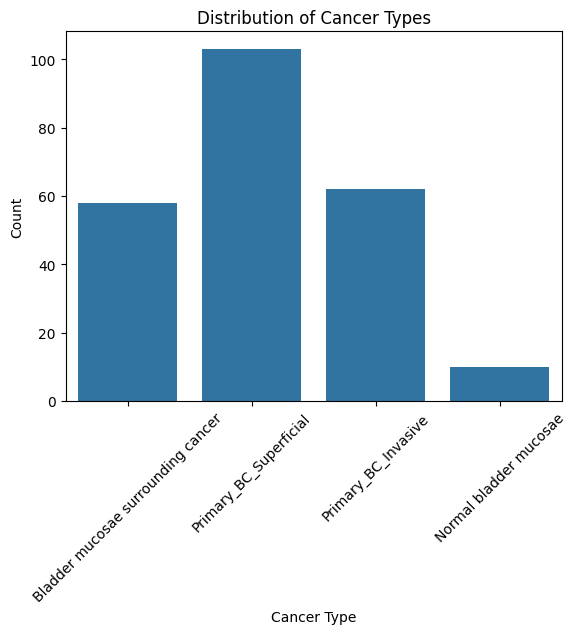

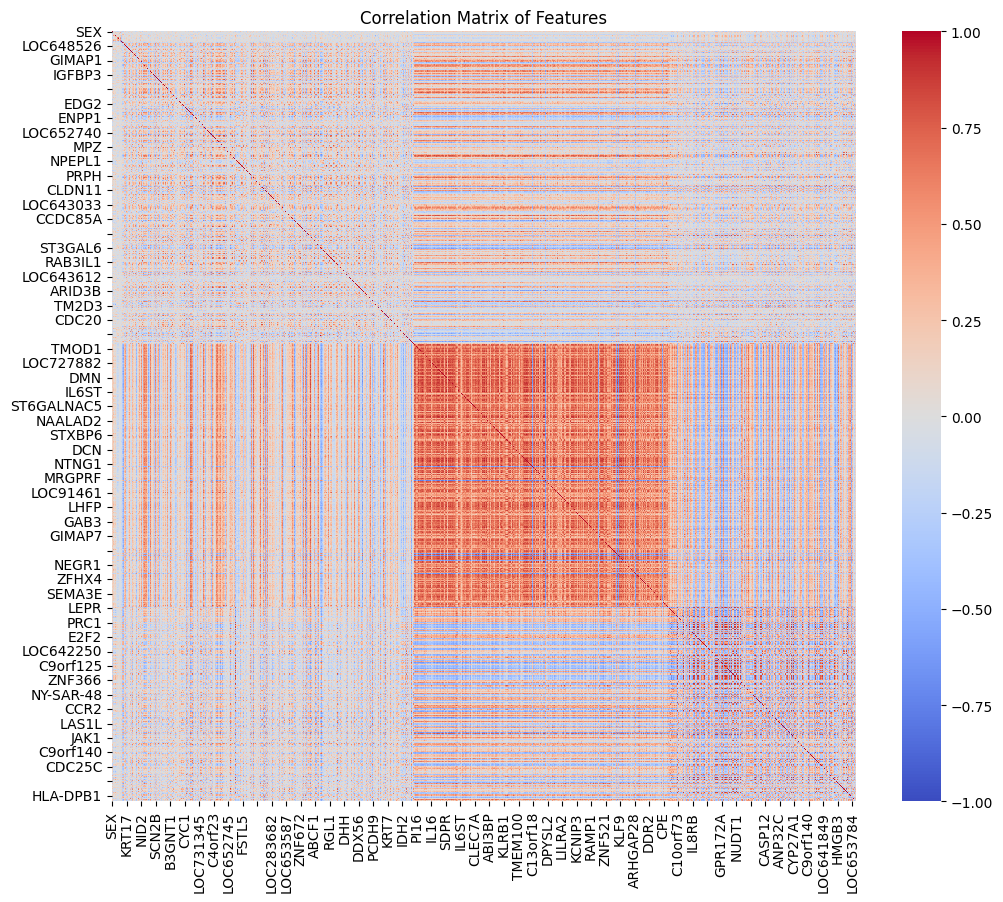

In [21]:
# Visualizing the distribution of cancer types
sns.countplot(x=y)
plt.title('Distribution of Cancer Types')
plt.xlabel('Cancer Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# Visualizing the correlation matrix
corr_matrix = X.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Features')
plt.show()

In [26]:
# Encoding the target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Selecting the top 50 features based on ANOVA F-value
selector = SelectKBest(score_func=f_classif, k=50)
X_selected = selector.fit_transform(X, y_encoded)

# Getting the selected feature names
selected_feature_names = X.columns[selector.get_support()]
print("Selected Features:")
print(selected_feature_names)

Selected Features:
Index(['Patient', 'GSMid', '!Sample_source_name_ch1', 'ALDH1A1', 'OLFM1',
       'SLIT2', 'ZNF536', 'PID1', '', 'SRPX', 'CYTL1', 'FAM107A', 'LPPR4',
       'GPR15', 'SYNE1', 'MOXD1', 'PAPPA', 'DPT', 'RECK', 'CD160', 'TCEAL2',
       'PLAC9', 'C2orf32', 'GLI1', 'FLJ21986', 'SMOC2', 'OLFML3', 'C4orf31',
       'CLIP3', 'ASPA', 'TIMP2', 'ABCA8', 'LOC221091', 'AFF3', 'ABI3BP',
       'PDGFC', 'FLNC', 'DCN', 'FOXF1', 'SGCE', 'AEBP1', 'MFAP4', 'COL16A1',
       'DKFZP586H2123', 'MYH11', 'ADAMTS8', 'PDGFRA', 'CFD', 'FGF9', 'LAMC3'],
      dtype='object')


/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [19] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: divide by zero encountered in divide
  f = msb / msw


# Step 5: Model Build

/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [19] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: divide by zero encountered in divide
  f = msb / msw


Selected Features:
Index(['Patient', 'GSMid', '!Sample_source_name_ch1', 'BCL2', 'ALDH1A1',
       'OLFM1', 'SLIT2', 'ZNF536', 'PID1', 'SORCS1', 'RAB3IL1', '', 'LRRK2',
       'SRPX', 'CYTL1', 'FAM107A', 'TMOD1', 'LPPR4', 'GPR15', 'FBLN5', 'HSPB6',
       'ADH1B', 'SYNE1', 'MOXD1', 'PAPPA', 'DPT', 'RECK', 'CD160', 'TCEAL2',
       'PLAC9', 'C2orf32', 'GLI1', 'FLJ21986', 'DIXDC1', 'FLJ22655', 'SMOC2',
       'OLFML3', 'COLEC12', 'ITM2A', 'COX7A1', 'C4orf31', 'CLIP3', 'GNG11',
       'ASPA', 'TIMP2', 'ABCA8', 'FGL2', 'LOC221091', 'TMEM16D', 'C1QTNF7',
       'JAM3', 'AFF3', 'ABI3BP', 'PDGFC', 'LRRC3B', 'GLT8D2', 'GULP1',
       'CYBRD1', 'TNC', 'CRISPLD2', 'FLNC', '', 'DCN', 'GHR', 'BIN1', 'OLFML1',
       'FOXF1', 'SGCE', 'AEBP1', 'EMILIN1', 'C1S', 'CDH11', 'MRGPRF', 'NOPE',
       'DPYSL2', 'MGLL', 'MFAP4', 'COL16A1', 'SPARCL1', 'C9orf19', 'PALLD',
       'PMP22', 'DKFZP586H2123', 'ADCY5', 'MYH11', 'ADAMTS8', 'SCARA5',
       'CALD1', 'TCF21', 'PDGFRA', 'CFD', 'SELM', 'PLA2G4C', 'FGF9'

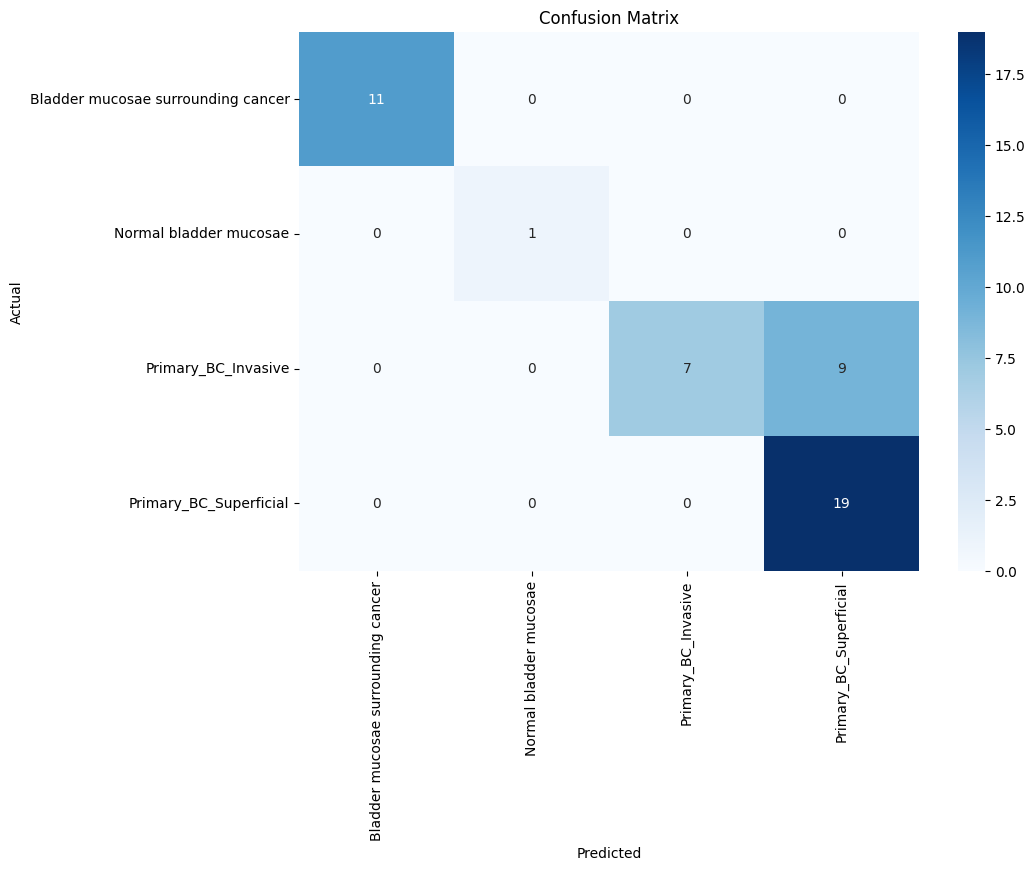

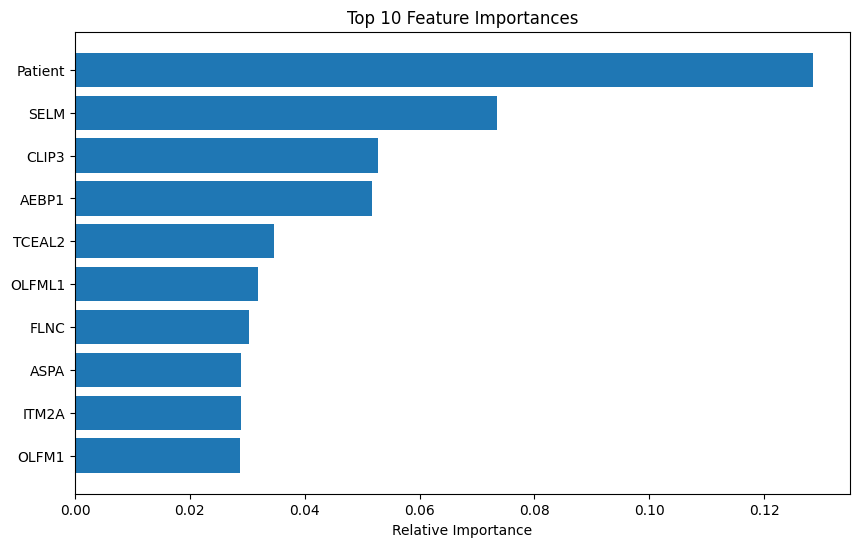

In [28]:
# Selecting the top 100 features based on ANOVA F-value
selector = SelectKBest(score_func=f_classif, k=100)
X_selected = selector.fit_transform(X, y_encoded)

# Getting the selected feature names
selected_feature_names = X.columns[selector.get_support()]
print("Selected Features:")
print(selected_feature_names)

# Spliting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_selected, y_encoded, test_size=0.2, random_state=42)

# Training an XGBoost model
model = XGBClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predicting on the test set
y_pred = model.predict(X_test)

# Evaluating the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Visualizing the confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Plotting feature importance
importances = model.feature_importances_
indices = np.argsort(importances)[-10:]  # Top 10 features

plt.figure(figsize=(10, 6))
plt.title('Top 10 Feature Importances')
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [selected_feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

## Interpretation
**High Precision and Recall for Some Classes:**

- The model performs perfectly for 'Bladder mucosae surrounding cancer' and 'Normal bladder mucosae' with 100% precision and recall.
- For 'Primary_BC_Invasive', the model has high precision but lower recall, indicating that it correctly identifies 'Primary_BC_Invasive' samples when it predicts them, but it misses some 'Primary_BC_Invasive' samples, predicting them as 'Primary_BC_Superficial' instead.
- For 'Primary_BC_Superficial', the model has a moderate precision of 0.68 but a high recall of 1.00, meaning it identifies all 'Primary_BC_Superficial' samples but also incorrectly predicts some 'Primary_BC_Invasive' samples as 'Primary_BC_Superficial'.


**Misclassification Issue:**

- The main issue lies in distinguishing between 'Primary_BC_Invasive' and 'Primary_BC_Superficial'. The model tends to misclassify 'Primary_BC_Invasive' samples as 'Primary_BC_Superficial'.

**Top Feature Importance:**

- The 'Patient' feature has the highest importance, indicating potential data leakage or overfitting issues related to patient-specific information.
Genes like SELM, CLIP3, AEBP1, and others are also important for predicting cancer types.

## Recommendations

**Investigating Patient Feature:**

- The 'Patient' feature having the highest importance suggests that the model may be using patient-specific information to make predictions, which might not generalize well to new patients. Need to consider removing or carefully handling this feature.

**Addressing Class Imbalance:**

- Explore techniques to handle the class imbalance, such as oversampling the 'Primary_BC_Invasive' class or undersampling the 'Primary_BC_Superficial' class to improve the model's performance in distinguishing between these classes.

**Feature Engineering:**

- Perform additional feature engineering to better capture the underlying patterns in the data and improve the model's ability to distinguish between similar classes.
By addressing these points, you can potentially improve the model's performance and make it more robust for predicting cancer types in new patients.

/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [18] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: divide by zero encountered in divide
  f = msb / msw


Selected Features:
Index(['GSMid', '!Sample_source_name_ch1', 'BCL2', 'ALDH1A1', 'OLFM1', 'SLIT2',
       'ZNF536', 'PID1', 'SORCS1', 'RAB3IL1', '', 'LRRK2', 'SRPX', 'CYTL1',
       'FAM107A', 'TMOD1', 'LPPR4', 'GPR15', 'FBLN5', 'HSPB6', 'ADH1B',
       'SYNE1', 'MOXD1', 'PAPPA', 'DPT', 'RECK', 'CD160', 'TCEAL2', 'PLAC9',
       'C2orf32', 'GLI1', 'FLJ21986', 'DIXDC1', 'FLJ22655', 'SMOC2', 'OLFML3',
       'COLEC12', 'ITM2A', 'COX7A1', 'C4orf31', 'CLIP3', 'GNG11', 'ASPA',
       'TIMP2', 'ABCA8', 'FGL2', 'LOC221091', 'TMEM16D', 'C1QTNF7', 'JAM3',
       'AFF3', 'ABI3BP', 'PDGFC', 'LRRC3B', 'GLT8D2', 'GULP1', 'CYBRD1', 'TNC',
       'CRISPLD2', 'FLNC', '', 'DCN', 'GHR', 'BIN1', 'OLFML1', 'FOXF1', 'SGCE',
       'AEBP1', 'EMILIN1', 'C1S', 'CDH11', 'MRGPRF', 'NOPE', 'DPYSL2', 'MGLL',
       'MFAP4', 'COL16A1', 'SPARCL1', 'C9orf19', 'PALLD', 'PMP22',
       'DKFZP586H2123', 'ADCY5', 'MYH11', 'ADAMTS8', 'SCARA5', 'CALD1',
       'TCF21', 'PDGFRA', 'CFD', 'SELM', 'PLA2G4C', 'FGF9', 'C21orf63

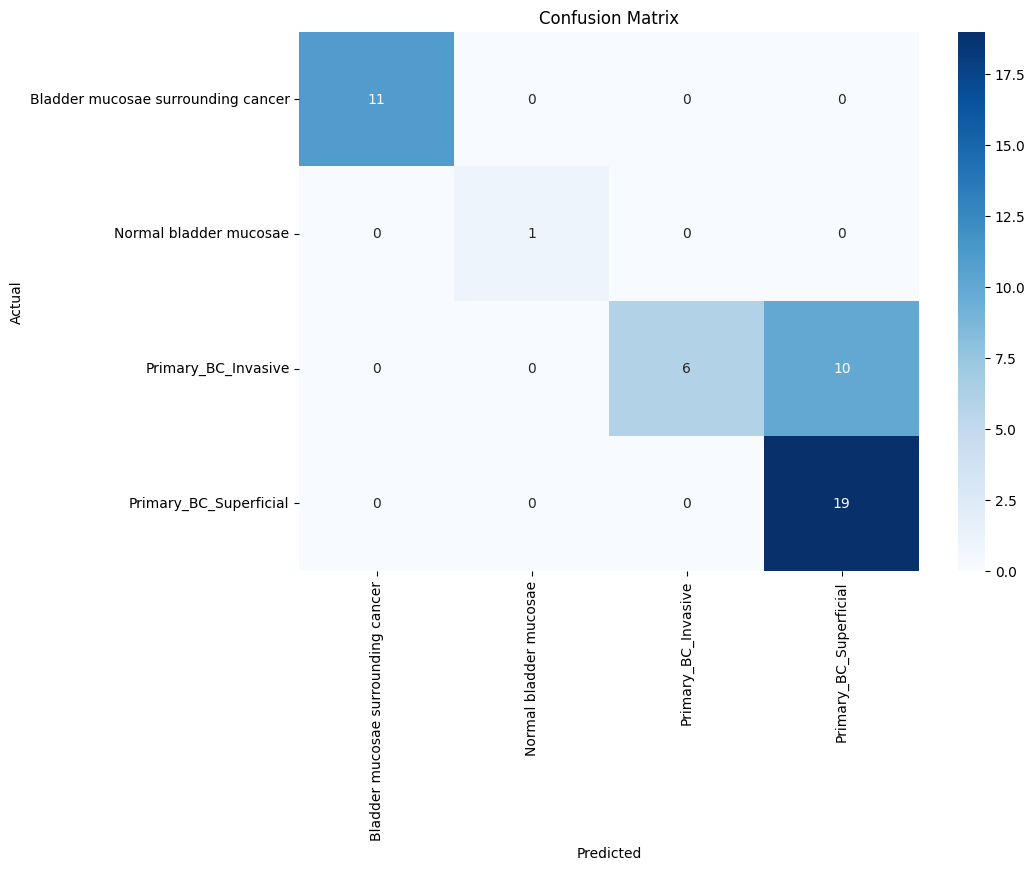

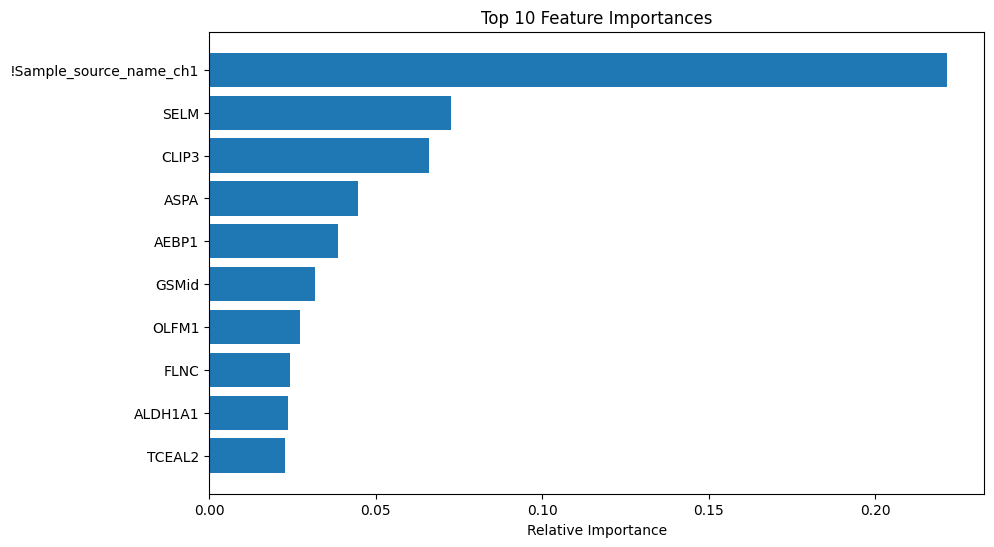

In [29]:
# Removing the 'Patient' feature
X = X.drop(columns=['Patient'])

# Re-runnnig feature selection and model training steps with the updated feature set
# Selecting the top 100 features based on ANOVA F-value
selector = SelectKBest(score_func=f_classif, k=100)
X_selected = selector.fit_transform(X, y_encoded)

# Getting the selected feature names
selected_feature_names = X.columns[selector.get_support()]
print("Selected Features:")
print(selected_feature_names)

# Spliting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_selected, y_encoded, test_size=0.2, random_state=42)

# Training an XGBoost model
model = XGBClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predicting on the test set
y_pred = model.predict(X_test)

# Evaluating the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Visualizing the confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Plotting feature importance
importances = model.feature_importances_
indices = np.argsort(importances)[-10:]  # Top 10 features

plt.figure(figsize=(10, 6))
plt.title('Top 10 Feature Importances')
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [selected_feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

Accuracy: 0.7446808510638298

Classification Report:
                                    precision    recall  f1-score   support

Bladder mucosae surrounding cancer       1.00      0.82      0.90        11
            Normal bladder mucosae       0.33      1.00      0.50         1
               Primary_BC_Invasive       0.75      0.56      0.64        16
            Primary_BC_Superficial       0.70      0.84      0.76        19

                          accuracy                           0.74        47
                         macro avg       0.69      0.81      0.70        47
                      weighted avg       0.78      0.74      0.75        47


Confusion Matrix:
[[ 9  2  0  0]
 [ 0  1  0  0]
 [ 0  0  9  7]
 [ 0  0  3 16]]


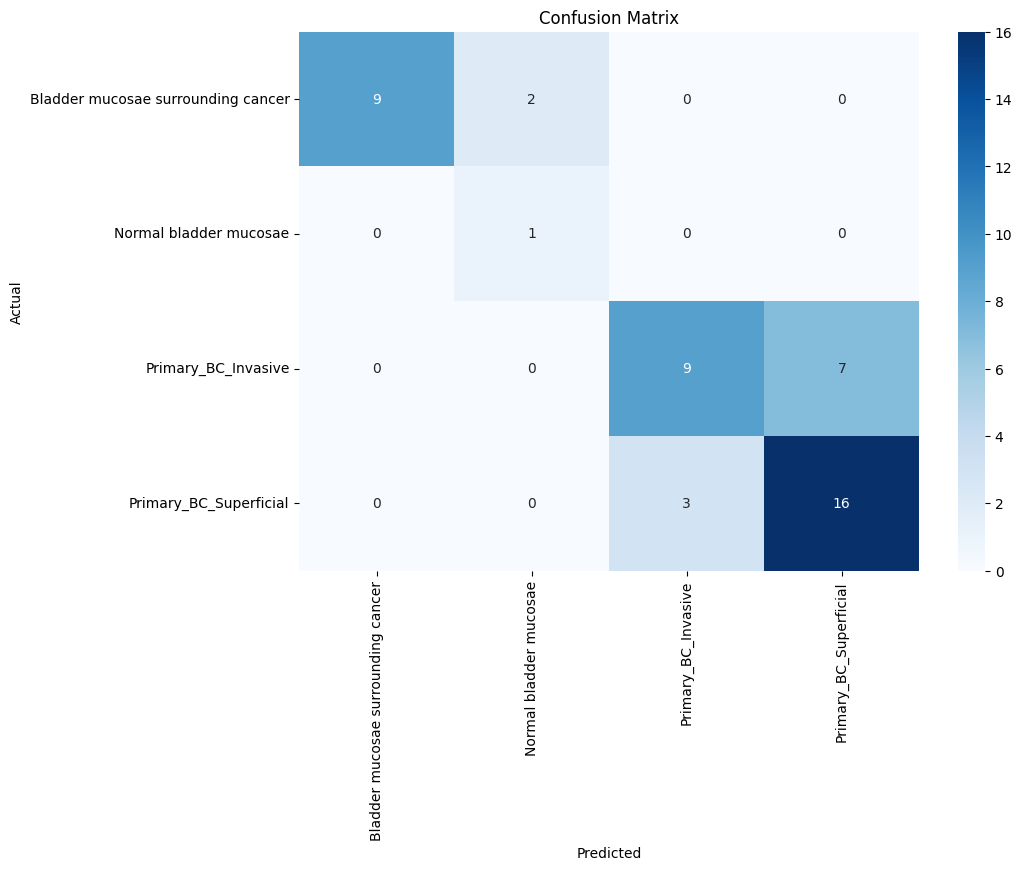

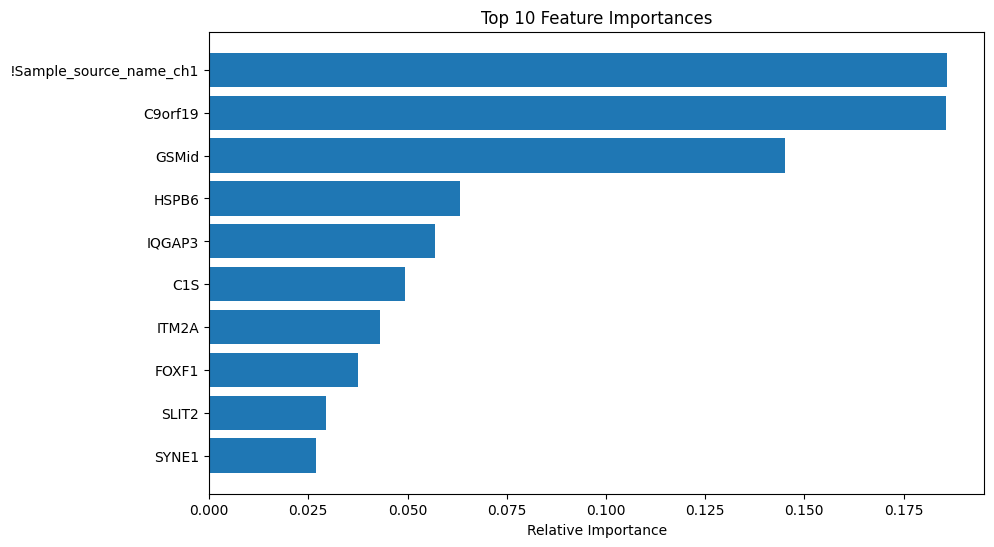

In [30]:
# Defining oversampling strategy
oversample = SMOTE()

# Defining undersampling strategy
undersample = RandomUnderSampler()

# Creating a pipeline with undersampling followed by oversampling
steps = [('under', undersample), ('over', oversample)]
pipeline = Pipeline(steps=steps)

# Applying resampling to the training data
X_resampled, y_resampled = pipeline.fit_resample(X_train, y_train)

# Training the XGBoost model on the resampled data
model = XGBClassifier(n_estimators=100, random_state=42)
model.fit(X_resampled, y_resampled)

# Predicting on the test set
y_pred = model.predict(X_test)

# Evaluating the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Visualizing the confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Plotting feature importance
importances = model.feature_importances_
indices = np.argsort(importances)[-10:]  # Top 10 features

plt.figure(figsize=(10, 6))
plt.title('Top 10 Feature Importances')
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [selected_feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

Accuracy: 0.8085106382978723

Classification Report:
                                    precision    recall  f1-score   support

Bladder mucosae surrounding cancer       1.00      1.00      1.00        11
            Normal bladder mucosae       1.00      1.00      1.00         1
               Primary_BC_Invasive       0.77      0.62      0.69        16
            Primary_BC_Superficial       0.73      0.84      0.78        19

                          accuracy                           0.81        47
                         macro avg       0.87      0.87      0.87        47
                      weighted avg       0.81      0.81      0.81        47


Confusion Matrix:
[[11  0  0  0]
 [ 0  1  0  0]
 [ 0  0 10  6]
 [ 0  0  3 16]]


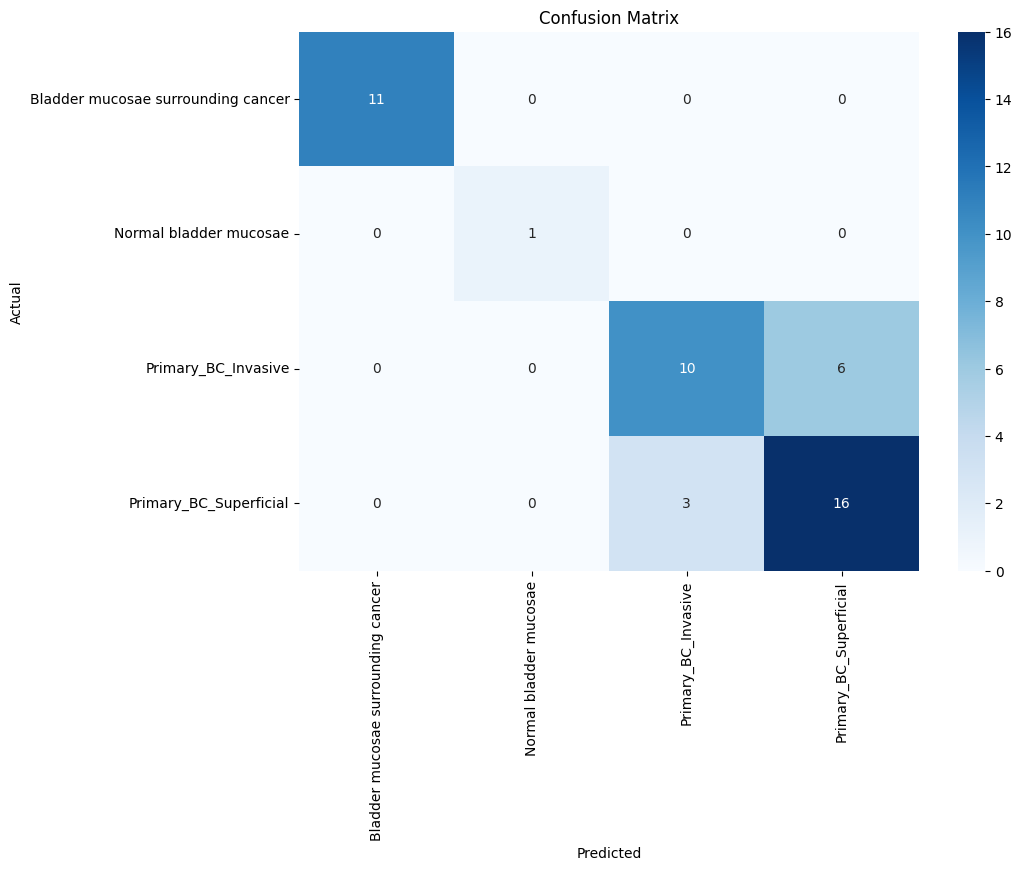

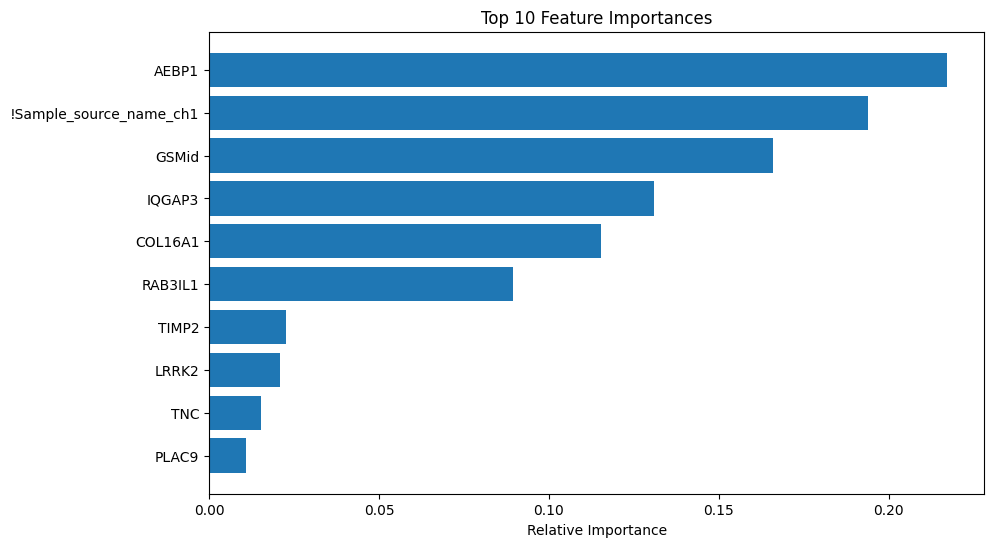

In [32]:
# Spliting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_selected, y_encoded, test_size=0.2, random_state=42)

# Defining oversampling and undersampling strategies
oversample = SMOTE()
undersample = RandomUnderSampler()

# Applying undersampling and oversampling
X_train_resampled, y_train_resampled = undersample.fit_resample(X_train, y_train)
X_train_resampled, y_train_resampled = oversample.fit_resample(X_train_resampled, y_train_resampled)

# Training an XGBoost model on the resampled data
model = XGBClassifier(n_estimators=100, random_state=42)
model.fit(X_train_resampled, y_train_resampled)

# Predicting on the test set
y_pred = model.predict(X_test)

# Evaluating the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Visualizing the confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Plot feature importance
importances = model.feature_importances_
indices = np.argsort(importances)[-10:]  # Top 10 features

plt.figure(figsize=(10, 6))
plt.title('Top 10 Feature Importances')
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [selected_feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

## Conclusion
The XGBoost model demonstrates strong predictive performance, with an accuracy of **80.85%** and high precision, recall, and F1-scores for most classes. However, the model shows some difficulty in distinguishing between 'Primary_BC_Invasive' and 'Primary_BC_Superficial', as indicated by the misclassifications in the confusion matrix.

The most important features identified by the model include both clinical metadata (such as !Sample_source_name_ch1 and GSMid) and specific genes (such as AEBP1 and IQGAP3). These features play a crucial role in the model's ability to predict cancer types accurately.

To further improve the model's performance, especially in distinguishing between similar classes, the following steps could be considered:

**Feature Engineering:** Create new features or interaction terms to better capture the underlying patterns in the data.

**Advanced Resampling Techniques:** Experiment with different resampling strategies or ensemble methods to address class imbalance.

**Hyperparameter Tuning:** Fine-tune the hyperparameters of the XGBoost model to optimize its performance.

Overall, the model provides valuable insights and demonstrates the potential for accurately predicting cancer types based on clinical and genomic data.

In [33]:
pip install jupyter

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.4/123.4 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.5/93.5 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 10.8 MB/s eta 0:00:00


In [ ]:
jupyter nbconvert --to html your_notebook.ipynb